<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms as tfs
sns.set(style="darkgrid", font_scale=1.4)
from tqdm import tqdm
from torchsummary import summary


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [3]:
np.info(X) # Для любопытства из чего состоит dataset(размерность shape:  (10000, 2))

class:  ndarray
shape:  (10000, 2)
strides:  (16, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7032000
byteorder:  little
byteswap:  False
type: float64


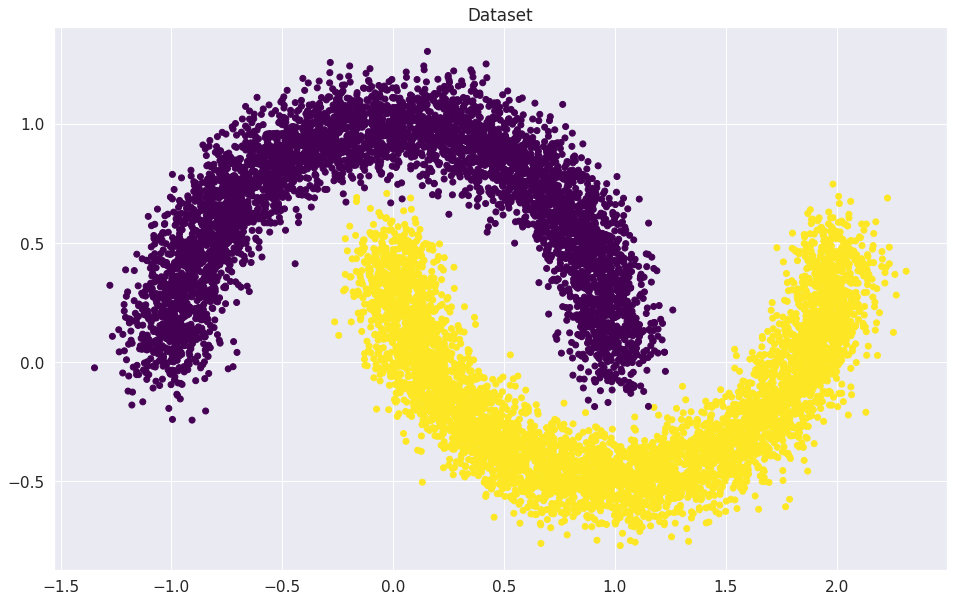

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42,)


### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
## X_train_t =  # YOUR CODE GOES HERE
## y_train_t =  # YOUR CODE GOES HERE
## X_val_t =  # YOUR CODE GOES HERE
## y_val_t =  # YOUR CODE GOES HERE

X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

In [7]:
X_train_t[0].dtype # Просмотрим на одном элементе тип данных. Должен быть torch.float32


torch.float32

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)#Для обучения
val_dataset = TensorDataset(X_val_t, y_val_t) #Для теста
train_dataloader = DataLoader(train_dataset, batch_size=128) # разбиваем на батчи для обучения
val_dataloader = DataLoader(val_dataset, batch_size=128) ## разбиваем на батчи тестовые данные

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        ## self.weights = nn.Parameter(torch.randn)
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            ## self.bias_term = # YOUR CODE GOES HERE
            self.bias_term = nn.Parameter(torch.randn(1))
            

    def forward(self, x):
        ## x =  # YOUR CODE GOES HERE
        x = x @ self.weights #Умножение матриц
        if self.bias:
            ## x +=  # YOUR CODE GOES HERE
            x += self.bias_term # Выполняем сложение
        return x

In [10]:
linear_regression = LinearRegression(2, 1,)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров. **Ответ**: обучаемых параметров -3. Проверка ниже.

In [11]:
# Посчитаем кол-во параметров()
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
param=count_parameters(linear_regression)
print(param)

3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # outp =  # YOUR CODE. Use linear_regression to get outputs
        # loss =  # YOUR CODE. Compute loss
        outp =  linear_regression(X_batch) # Применим линейную регрессию
        loss =  loss_function(outp, y_batch) # Комбинируем сигмоиду и кросс-энтропию
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        # probabilities =  # YOUR CODE. Compute probabilities
        probabilities =  F.sigmoid(outp)# Вычислим вероятности
        
        preds = (probabilities > 0.5).type(torch.long)
        
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 0.8203125
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.828125
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625

Iteration: 582.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  700.


### Визуализируем результаты

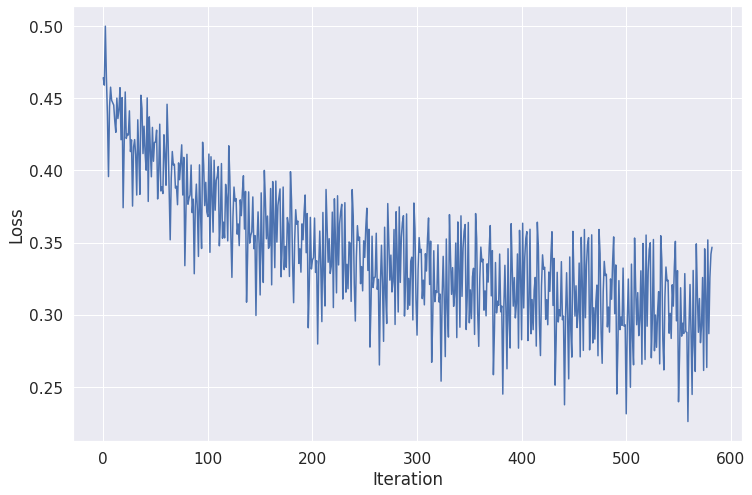

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

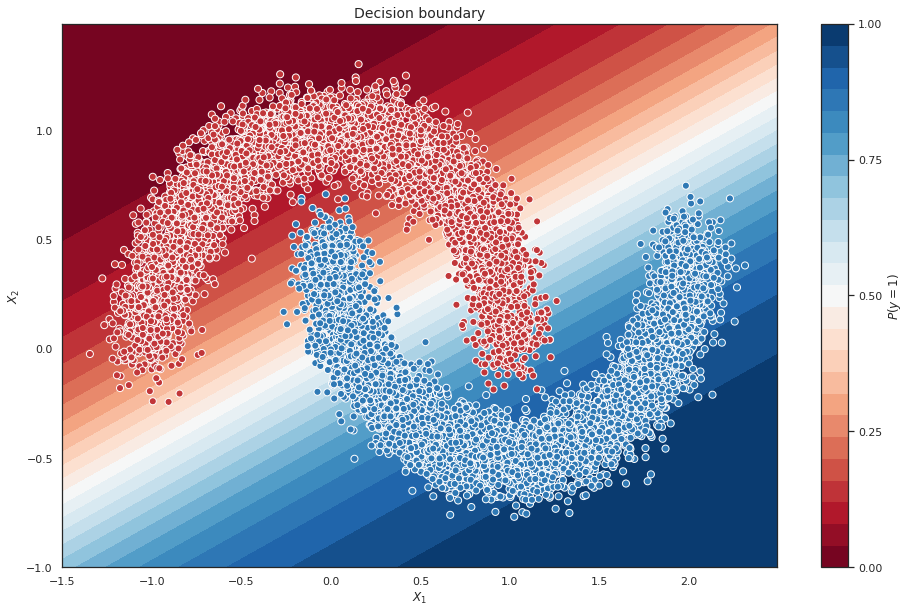

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #         
        # preds = #YOUR CODE. Compute predictions
        preds = linear_regression(x_batch) # Вычислим прогноз
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
probabilities =  F.sigmoid(torch.from_numpy(predict(val_dataloader, linear_regression)))
preds = (probabilities > 0.5).type(torch.long)
accuracy_score(y_val, preds)

0.8656

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.866 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [17]:
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])


# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

# YOUR CODE GOES HERE

train_dataloader = DataLoader(train_dataset, 
                             batch_size=100, 
                             shuffle=True,
                             pin_memory=True,
                             num_workers=2)
# YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, 
                              batch_size=100, 
                              shuffle=False, 
                              pin_memory=True,
                              num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [18]:
# Посмотрим результаты
train_dataloader.dataset.data.shape, valid_dataloader.dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU

    #YOUR CODE. Add layers to your sequential class
    # 784 получается так как входящие данные 28х28
model = nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(784, 128),
    activation(), 
    torch.nn.Linear(128, 128),
    activation(), 
    torch.nn.Linear(128, 10),
    torch.nn.Softmax()
)

In [21]:
!pip install torchsummary
from torchsummary import summary
summary(model.cuda(), (28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
               ELU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
               ELU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
           Softmax-7                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [22]:
#YOUR CODE. Select a loss function
criterion = nn.CrossEntropyLoss() # лосс для обучения (кросс-энтропия)
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [24]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in tqdm(loaders.items()):
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. 
                # Don't forget zero_grad!
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            # correct =  # YOUR CODE GOES HERE
            # all =  # YOUR CODE GOES HERE
            all = y_batch.shape[0]
            correct =  (preds == y_batch.to(device)).sum()
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


 50%|█████     | 1/2 [00:11<00:11, 11.03s/it]

Epoch: 1
Loader: train. Accuracy: 0.8621



 10%|█         | 1/10 [00:12<01:54, 12.72s/it]

Loader: valid. Accuracy: 0.9189



 50%|█████     | 1/2 [00:17<00:17, 17.02s/it]

Epoch: 2
Loader: train. Accuracy: 0.9242666666666667



 20%|██        | 2/10 [00:33<02:19, 17.40s/it]

Loader: valid. Accuracy: 0.9396



 50%|█████     | 1/2 [00:13<00:13, 13.32s/it]

Epoch: 3
Loader: train. Accuracy: 0.9401666666666667



 30%|███       | 3/10 [00:48<01:54, 16.30s/it]

Loader: valid. Accuracy: 0.9459



 50%|█████     | 1/2 [00:09<00:09,  9.97s/it]

Epoch: 4
Loader: train. Accuracy: 0.9497333333333333



 40%|████      | 4/10 [00:59<01:26, 14.44s/it]

Loader: valid. Accuracy: 0.9484



 50%|█████     | 1/2 [00:09<00:09,  9.82s/it]

Epoch: 5
Loader: train. Accuracy: 0.95575



 50%|█████     | 5/10 [01:11<01:06, 13.36s/it]

Loader: valid. Accuracy: 0.9572



 50%|█████     | 1/2 [00:09<00:09,  9.88s/it]

Epoch: 6
Loader: train. Accuracy: 0.9601833333333334



 60%|██████    | 6/10 [01:22<00:50, 12.74s/it]

Loader: valid. Accuracy: 0.9586



 50%|█████     | 1/2 [00:09<00:09,  9.86s/it]

Epoch: 7
Loader: train. Accuracy: 0.96305



 70%|███████   | 7/10 [01:34<00:37, 12.34s/it]

Loader: valid. Accuracy: 0.9641



 50%|█████     | 1/2 [00:09<00:09,  9.86s/it]

Epoch: 8
Loader: train. Accuracy: 0.9667833333333333



 80%|████████  | 8/10 [01:45<00:24, 12.06s/it]

Loader: valid. Accuracy: 0.9622



 50%|█████     | 1/2 [00:09<00:09,  9.87s/it]

Epoch: 9
Loader: train. Accuracy: 0.9691833333333333



 90%|█████████ | 9/10 [01:57<00:11, 11.87s/it]

Loader: valid. Accuracy: 0.9581



 50%|█████     | 1/2 [00:09<00:09,  9.86s/it]

Epoch: 10
Loader: train. Accuracy: 0.9697833333333333



100%|██████████| 10/10 [02:08<00:00, 12.89s/it]

Loader: valid. Accuracy: 0.9668


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [25]:
elu_accuracy = accuracy["valid"]

In [26]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def test_activation_function(activation):
    # создаем модель, "забрасываем ее на куду", оптимизатор не забываем
    model = nn.Sequential(
        nn.Flatten(),
        torch.nn.Linear(784, 128),
        activation(), 
        torch.nn.Linear(128, 128),
        activation(), 
        torch.nn.Linear(128, 10),
        torch.nn.Softmax()
    )
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in tqdm(loaders.items()):
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    model.eval()
                    outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                all = y_batch.shape[0]
                correct =  (preds == y_batch.to(device)).sum()
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [27]:
plain_accuracy = test_activation_function(Identical)
# relu_accuracy = #YOUR CODE
# leaky_relu_accuracy = #YOUR CODE
#
relu_accuracy = test_activation_function(nn.ReLU) 
#
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

 50%|█████     | 1/2 [00:10<00:10, 10.92s/it]

Epoch: 1
Loader: train. Accuracy: 0.8519333333333333



 10%|█         | 1/10 [00:12<01:52, 12.52s/it]

Loader: valid. Accuracy: 0.8975



 50%|█████     | 1/2 [00:09<00:09,  9.71s/it]

Epoch: 2
Loader: train. Accuracy: 0.8914666666666666



 20%|██        | 2/10 [00:23<01:34, 11.83s/it]

Loader: valid. Accuracy: 0.8876



 50%|█████     | 1/2 [00:09<00:09,  9.78s/it]

Epoch: 3
Loader: train. Accuracy: 0.8962833333333333



 30%|███       | 3/10 [00:35<01:21, 11.63s/it]

Loader: valid. Accuracy: 0.9083



 50%|█████     | 1/2 [00:09<00:09,  9.68s/it]

Epoch: 4
Loader: train. Accuracy: 0.8957833333333334



 40%|████      | 4/10 [00:46<01:09, 11.51s/it]

Loader: valid. Accuracy: 0.9045



 50%|█████     | 1/2 [00:09<00:09,  9.89s/it]

Epoch: 5
Loader: train. Accuracy: 0.8940833333333333



 50%|█████     | 5/10 [00:58<00:57, 11.52s/it]

Loader: valid. Accuracy: 0.8922



 50%|█████     | 1/2 [00:09<00:09,  9.82s/it]

Epoch: 6
Loader: train. Accuracy: 0.8931166666666667



 60%|██████    | 6/10 [01:09<00:46, 11.50s/it]

Loader: valid. Accuracy: 0.9002



 50%|█████     | 1/2 [00:09<00:09,  9.68s/it]

Epoch: 7
Loader: train. Accuracy: 0.8942



 70%|███████   | 7/10 [01:20<00:34, 11.44s/it]

Loader: valid. Accuracy: 0.9018



 50%|█████     | 1/2 [00:09<00:09,  9.76s/it]

Epoch: 8
Loader: train. Accuracy: 0.8975333333333333



 80%|████████  | 8/10 [01:32<00:22, 11.42s/it]

Loader: valid. Accuracy: 0.8993



 50%|█████     | 1/2 [00:09<00:09,  9.91s/it]

Epoch: 9
Loader: train. Accuracy: 0.8946



 90%|█████████ | 9/10 [01:43<00:11, 11.47s/it]

Loader: valid. Accuracy: 0.8882



 50%|█████     | 1/2 [00:09<00:09,  9.84s/it]

Epoch: 10
Loader: train. Accuracy: 0.8930166666666667



100%|██████████| 10/10 [01:55<00:00, 11.53s/it]


Loader: valid. Accuracy: 0.8967


 50%|█████     | 1/2 [00:10<00:10, 10.02s/it]

Epoch: 1
Loader: train. Accuracy: 0.83225



 10%|█         | 1/10 [00:11<01:44, 11.66s/it]

Loader: valid. Accuracy: 0.8885



 50%|█████     | 1/2 [00:10<00:10, 10.83s/it]

Epoch: 2
Loader: train. Accuracy: 0.9200333333333334



 20%|██        | 2/10 [00:24<01:37, 12.24s/it]

Loader: valid. Accuracy: 0.9283



 50%|█████     | 1/2 [00:10<00:10, 10.54s/it]

Epoch: 3
Loader: train. Accuracy: 0.9379333333333333



 30%|███       | 3/10 [00:36<01:26, 12.42s/it]

Loader: valid. Accuracy: 0.9344



 50%|█████     | 1/2 [00:10<00:10, 10.09s/it]

Epoch: 4
Loader: train. Accuracy: 0.9461666666666667



 40%|████      | 4/10 [00:48<01:12, 12.16s/it]

Loader: valid. Accuracy: 0.9408



 50%|█████     | 1/2 [00:10<00:10, 10.11s/it]

Epoch: 5
Loader: train. Accuracy: 0.9529333333333333



 50%|█████     | 5/10 [01:00<01:00, 12.03s/it]

Loader: valid. Accuracy: 0.9553



 50%|█████     | 1/2 [00:09<00:09,  9.93s/it]

Epoch: 6
Loader: train. Accuracy: 0.9581666666666667



 60%|██████    | 6/10 [01:12<00:47, 11.88s/it]

Loader: valid. Accuracy: 0.9586



 50%|█████     | 1/2 [00:09<00:09,  9.79s/it]

Epoch: 7
Loader: train. Accuracy: 0.9605333333333334



 70%|███████   | 7/10 [01:23<00:35, 11.74s/it]

Loader: valid. Accuracy: 0.962



 50%|█████     | 1/2 [00:09<00:09,  9.87s/it]

Epoch: 8
Loader: train. Accuracy: 0.9642333333333334



 80%|████████  | 8/10 [01:35<00:23, 11.68s/it]

Loader: valid. Accuracy: 0.9576



 50%|█████     | 1/2 [00:09<00:09,  9.88s/it]

Epoch: 9
Loader: train. Accuracy: 0.9660833333333333



 90%|█████████ | 9/10 [01:46<00:11, 11.62s/it]

Loader: valid. Accuracy: 0.954



 50%|█████     | 1/2 [00:09<00:09,  9.84s/it]

Epoch: 10
Loader: train. Accuracy: 0.9665333333333334



100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


Loader: valid. Accuracy: 0.9617


 50%|█████     | 1/2 [00:09<00:09,  9.98s/it]

Epoch: 1
Loader: train. Accuracy: 0.8542



 10%|█         | 1/10 [00:11<01:44, 11.57s/it]

Loader: valid. Accuracy: 0.9121



 50%|█████     | 1/2 [00:09<00:09,  9.85s/it]

Epoch: 2
Loader: train. Accuracy: 0.9233666666666667



 20%|██        | 2/10 [00:23<01:31, 11.50s/it]

Loader: valid. Accuracy: 0.9394



 50%|█████     | 1/2 [00:09<00:09,  9.82s/it]

Epoch: 3
Loader: train. Accuracy: 0.9386833333333333



 30%|███       | 3/10 [00:34<01:20, 11.46s/it]

Loader: valid. Accuracy: 0.9386



 50%|█████     | 1/2 [00:09<00:09,  9.81s/it]

Epoch: 4
Loader: train. Accuracy: 0.9479833333333333



 40%|████      | 4/10 [00:45<01:08, 11.45s/it]

Loader: valid. Accuracy: 0.9473



 50%|█████     | 1/2 [00:09<00:09,  9.83s/it]

Epoch: 5
Loader: train. Accuracy: 0.9532833333333334



 50%|█████     | 5/10 [00:57<00:57, 11.47s/it]

Loader: valid. Accuracy: 0.9472



 50%|█████     | 1/2 [00:10<00:10, 10.96s/it]

Epoch: 6
Loader: train. Accuracy: 0.9587166666666667



 60%|██████    | 6/10 [01:10<00:47, 11.87s/it]

Loader: valid. Accuracy: 0.9604



 50%|█████     | 1/2 [00:10<00:10, 10.68s/it]

Epoch: 7
Loader: train. Accuracy: 0.9604666666666667



 70%|███████   | 7/10 [01:22<00:36, 12.02s/it]

Loader: valid. Accuracy: 0.9632



 50%|█████     | 1/2 [00:09<00:09,  9.93s/it]

Epoch: 8
Loader: train. Accuracy: 0.9629333333333333



 80%|████████  | 8/10 [01:33<00:23, 11.87s/it]

Loader: valid. Accuracy: 0.9636



 50%|█████     | 1/2 [00:10<00:10, 10.04s/it]

Epoch: 9
Loader: train. Accuracy: 0.9637



 90%|█████████ | 9/10 [01:45<00:11, 11.83s/it]

Loader: valid. Accuracy: 0.9624



 50%|█████     | 1/2 [00:10<00:10, 10.03s/it]

Epoch: 10
Loader: train. Accuracy: 0.9660666666666666



100%|██████████| 10/10 [01:57<00:00, 11.73s/it]

Loader: valid. Accuracy: 0.9646


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

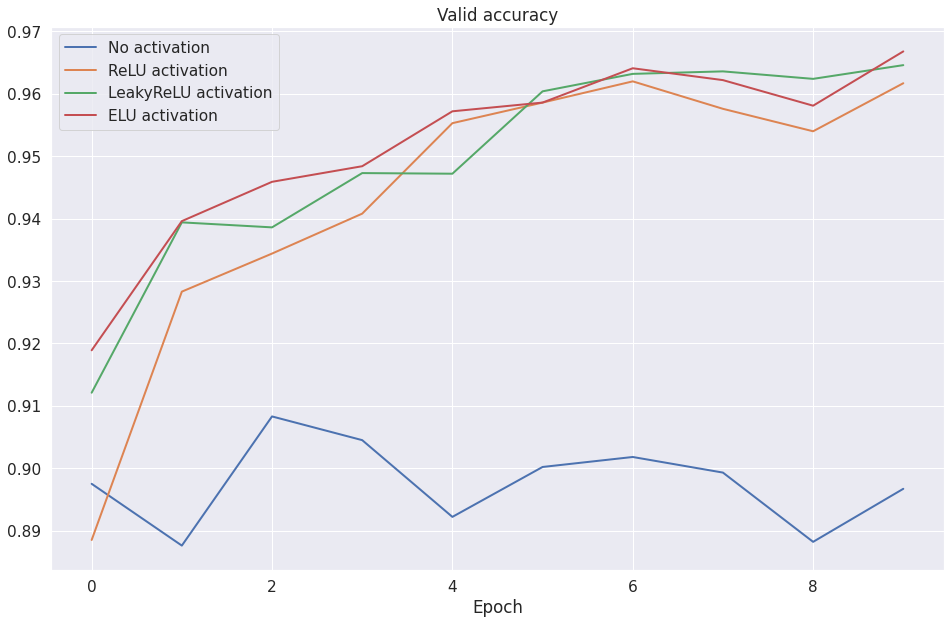

In [28]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

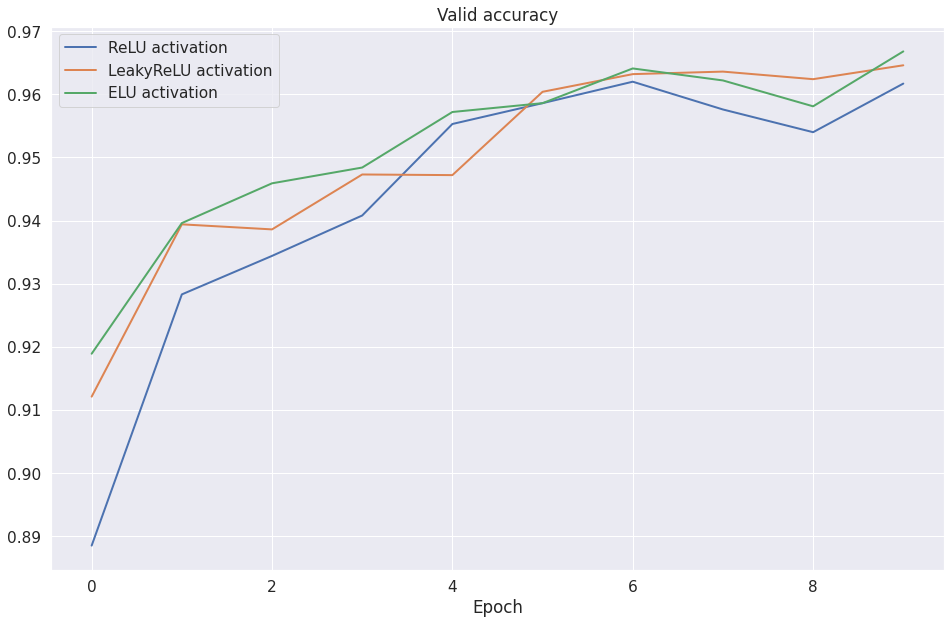

In [29]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [30]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-12-03 06:10:04--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-12-03 06:10:05--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   120KB/s    in 0.4s    

2022-12-03 06:10:07 (120 KB/s) - ‘sample_photo.jpg’ saved [49337/4

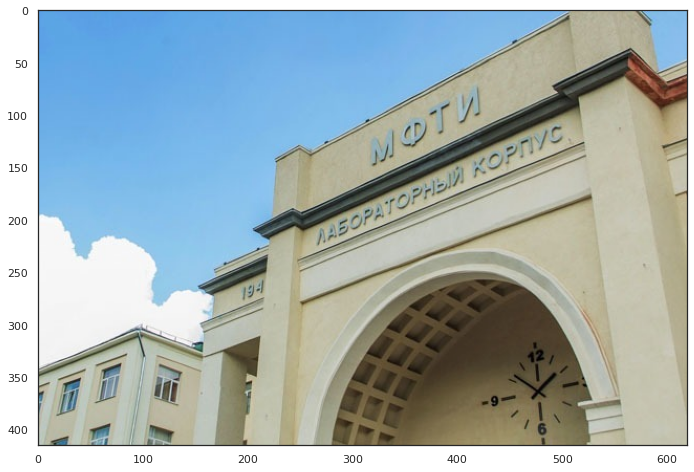

In [31]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [32]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

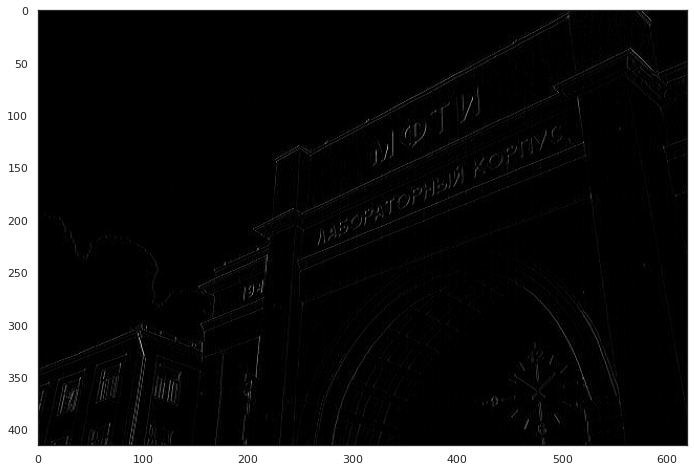

In [33]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - A

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:**A - 3, Б - 5, B - 4, Г - 6, Д - 2, Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [34]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # self.pool1 = #YOUR CODE
        # self.conv2 = #YOUR CODE
        # self.pool2 = #YOUR CODE
        # self.fc1 = #YOUR CODE  
        # self.fc2 = #YOUR CODE
        # self.fc3 = #YOUR CODE


    def forward(self, x):
        # x = #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [36]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in tqdm(loaders.items()):
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            all = y_batch.shape[0]
            correct =  (preds == y_batch.to(device)).sum()
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

 50%|█████     | 1/2 [00:14<00:14, 14.91s/it]

Epoch: 1
Loader: train. Accuracy: 0.8981666666666667



 10%|█         | 1/10 [00:16<02:29, 16.65s/it]

Loader: valid. Accuracy: 0.9676



 50%|█████     | 1/2 [00:10<00:10, 10.68s/it]

Epoch: 2
Loader: train. Accuracy: 0.9714833333333334



 20%|██        | 2/10 [00:29<01:53, 14.18s/it]

Loader: valid. Accuracy: 0.9797



 50%|█████     | 1/2 [00:10<00:10, 10.73s/it]

Epoch: 3
Loader: train. Accuracy: 0.97985



 30%|███       | 3/10 [00:41<01:33, 13.38s/it]

Loader: valid. Accuracy: 0.9824



 50%|█████     | 1/2 [00:10<00:10, 10.73s/it]

Epoch: 4
Loader: train. Accuracy: 0.9841166666666666



 40%|████      | 4/10 [00:53<01:18, 13.02s/it]

Loader: valid. Accuracy: 0.9864



 50%|█████     | 1/2 [00:10<00:10, 10.83s/it]

Epoch: 5
Loader: train. Accuracy: 0.9861166666666666



 50%|█████     | 5/10 [01:06<01:04, 12.87s/it]

Loader: valid. Accuracy: 0.9861



 50%|█████     | 1/2 [00:10<00:10, 10.70s/it]

Epoch: 6
Loader: train. Accuracy: 0.9882166666666666



 60%|██████    | 6/10 [01:19<00:50, 12.73s/it]

Loader: valid. Accuracy: 0.9873



 50%|█████     | 1/2 [00:17<00:17, 17.98s/it]

Epoch: 7
Loader: train. Accuracy: 0.99015



 70%|███████   | 7/10 [01:40<00:46, 15.59s/it]

Loader: valid. Accuracy: 0.9866



 50%|█████     | 1/2 [00:12<00:12, 12.69s/it]

Epoch: 8
Loader: train. Accuracy: 0.9912833333333333



 80%|████████  | 8/10 [01:54<00:30, 15.22s/it]

Loader: valid. Accuracy: 0.988



 50%|█████     | 1/2 [00:11<00:11, 11.03s/it]

Epoch: 9
Loader: train. Accuracy: 0.9925



 90%|█████████ | 9/10 [02:07<00:14, 14.48s/it]

Loader: valid. Accuracy: 0.9901



 50%|█████     | 1/2 [00:10<00:10, 10.94s/it]

Epoch: 10
Loader: train. Accuracy: 0.9935666666666667



100%|██████████| 10/10 [02:20<00:00, 14.05s/it]

Loader: valid. Accuracy: 0.9902


In [37]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

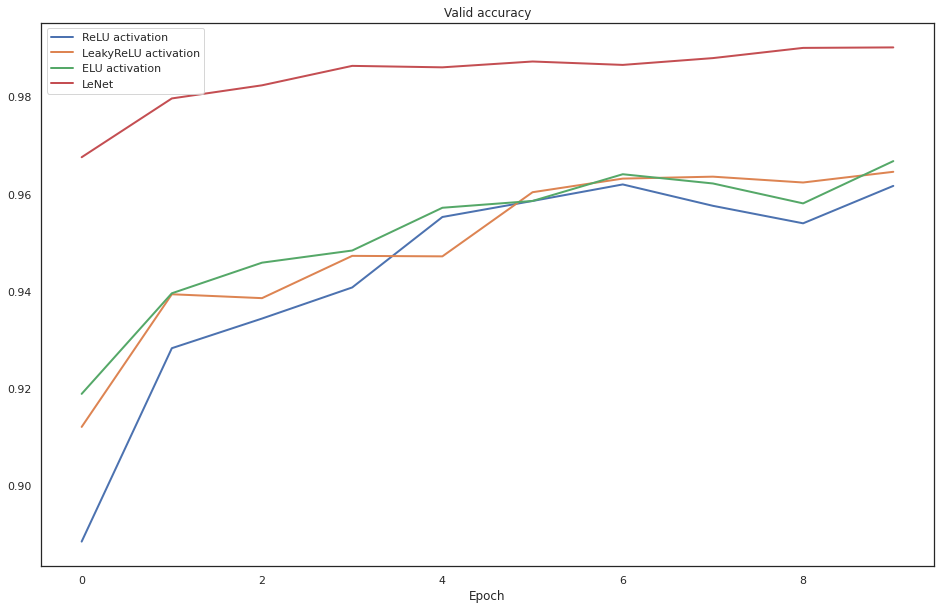

In [38]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [39]:
round(lenet_accuracy[-1], 2) # Округлим

0.99

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99